In [8]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix


data_dir = "D:\\PythonStore\\FInalProject\\asl_alphabet_train\\asl_alphabet_train"  
batch_size = 32
num_epochs = 20
num_classes = 29
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
# ========== Image preprocessing ==========
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.7,1.0), ratio=(0.75,1.33)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])
val_test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [10]:
# ========== Load and partition the dataset ==========
full_dataset = datasets.ImageFolder(data_dir, transform=train_transform)
n_total      = len(full_dataset)
n_val        = int(0.3 * n_total)
n_test       = int(0.3 * n_total)
n_train      = n_total - n_val - n_test
train_ds, val_ds, test_ds = random_split(full_dataset, [n_train, n_val, n_test])

val_ds.dataset.transform  = val_test_transform
test_ds.dataset.transform = val_test_transform

train_loader = DataLoader(train_ds,   batch_size=batch_size, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,     batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,    batch_size=batch_size, shuffle=False, num_workers=2)

In [11]:
# ========== Defining the MLP model ==========
class MLP(nn.Module):
    def __init__(self, input_size=64*64*3, hidden_sizes=[1024, 512], num_classes=29):
        super().__init__()
        layers, in_size = [], input_size
        for h in hidden_sizes:
            layers += [
                nn.Linear(in_size, h),
                nn.ReLU(),
                nn.Dropout(0.5)        
            ]
            in_size = h
        layers.append(nn.Linear(in_size, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

model     = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4         # L2
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=True
)

In [12]:
# ===== Training function =====
def train_model(model, train_loader, val_loader, epochs):
    best_acc = 0.0
    history  = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

    for epoch in range(1, epochs+1):
        model.train()
        running_loss, running_corrects = 0.0, 0
        for X, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} Train", leave=False):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss= criterion(out, y)
            loss.backward()
            optimizer.step()
            preds = out.argmax(1)
            running_loss     += loss.item() * X.size(0)
            running_corrects += (preds == y).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc  = running_corrects / len(train_loader.dataset)

        model.eval()
        vloss, vcorrects = 0.0, 0
        with torch.no_grad():
            for X, y in tqdm(val_loader, desc=" Validation", leave=False):
                X, y  = X.to(device), y.to(device)
                out   = model(X)
                loss  = criterion(out, y)
                preds = out.argmax(1)
                vloss     += loss.item() * X.size(0)
                vcorrects += (preds == y).sum().item()

        val_loss = vloss / len(val_loader.dataset)
        val_acc  = vcorrects / len(val_loader.dataset)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f} Train Acc={train_acc:.4f} | Val Loss={val_loss:.4f} Val Acc={val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            os.makedirs("models", exist_ok=True)
            torch.save(model.state_dict(), "models/best_mlp.pth")

    return history

In [13]:
# ========== Drawing functions ==========
def plot_history(history):
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"],   label="Val Loss")
    plt.title("Loss Curve"); plt.xlabel("Epoch"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"],   label="Val Acc")
    plt.title("Accuracy Curve"); plt.xlabel("Epoch"); plt.legend()
    plt.tight_layout(); plt.show()

Epoch 1/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 2: Train Loss=2.5046 Train Acc=0.2536 | Val Loss=1.6989 Val Acc=0.4996


Epoch 2/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 3: Train Loss=1.6967 Train Acc=0.4521 | Val Loss=1.1688 Val Acc=0.6621


Epoch 3/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 4: Train Loss=1.2996 Train Acc=0.5688 | Val Loss=0.9022 Val Acc=0.7231


Epoch 4/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 5: Train Loss=1.0535 Train Acc=0.6425 | Val Loss=0.6773 Val Acc=0.8058


Epoch 5/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.8810 Train Acc=0.6993 | Val Loss=0.5598 Val Acc=0.8395


Epoch 6/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.7630 Train Acc=0.7380 | Val Loss=0.4641 Val Acc=0.8698


Epoch 7/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.6693 Train Acc=0.7722 | Val Loss=0.3933 Val Acc=0.8874


Epoch 8/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.5979 Train Acc=0.7956 | Val Loss=0.3661 Val Acc=0.8933


Epoch 9/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.5404 Train Acc=0.8143 | Val Loss=0.3150 Val Acc=0.9155


Epoch 10/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.4982 Train Acc=0.8287 | Val Loss=0.2794 Val Acc=0.9216


Epoch 11/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.4665 Train Acc=0.8393 | Val Loss=0.2717 Val Acc=0.9213


Epoch 12/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.4300 Train Acc=0.8516 | Val Loss=0.2410 Val Acc=0.9327


Epoch 13/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.4066 Train Acc=0.8585 | Val Loss=0.2197 Val Acc=0.9359


Epoch 14/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.3896 Train Acc=0.8652 | Val Loss=0.2293 Val Acc=0.9314


Epoch 15/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.3729 Train Acc=0.8726 | Val Loss=0.2027 Val Acc=0.9410


Epoch 16/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.3531 Train Acc=0.8788 | Val Loss=0.1918 Val Acc=0.9432


Epoch 17/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.3369 Train Acc=0.8840 | Val Loss=0.1649 Val Acc=0.9521


Epoch 18/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.3209 Train Acc=0.8891 | Val Loss=0.1575 Val Acc=0.9554


Epoch 19/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.3141 Train Acc=0.8907 | Val Loss=0.1563 Val Acc=0.9538


Epoch 20/20 Train:   0%|          | 0/1088 [00:00<?, ?it/s]

 Validation:   0%|          | 0/816 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.3003 Train Acc=0.8967 | Val Loss=0.1500 Val Acc=0.9584


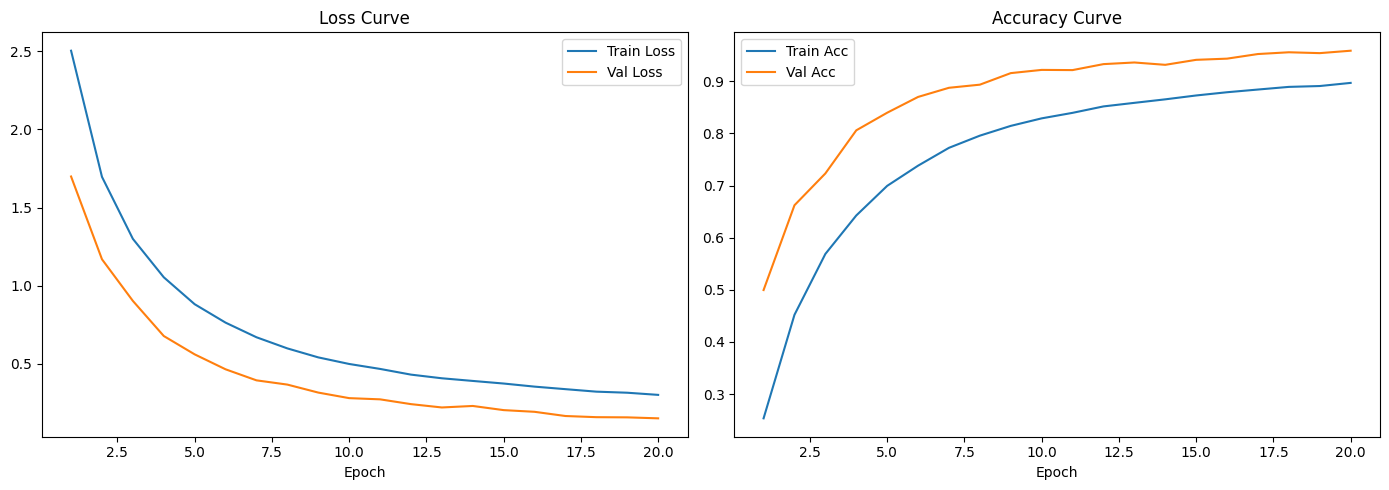

In [20]:
# ========== Train and visualize ==========
history = train_model(model, train_loader, val_loader, num_epochs)
plot_history(history)

In [14]:
# ========== Model Evaluation ==========
mlp = MLP().to(device)
mlp.load_state_dict(torch.load("models/best_mlp.pth", map_location=device))
mlp.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = mlp(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ========== Output evaluation indicators ==========
precision = precision_score(all_labels, all_preds, average='macro')
recall    = recall_score(all_labels, all_preds, average='macro')
f1        = f1_score(all_labels, all_preds, average='macro')
acc       = accuracy_score(all_labels, all_preds)

print(f"\nPrecision = {precision:.4f}")
print(f"Recall    = {recall:.4f}")
print(f"F1 Score  = {f1:.4f}")
print(f"Accuracy  = {acc:.2%}")

C:\Users\Manson\AppData\Local\Temp\ipykernel_22100\1027213349.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp.load_state_dict(torch.load("models/best_mlp.pth", map_l


Precision = 0.9652
Recall    = 0.9643
F1 Score  = 0.9644
Accuracy  = 96.43%


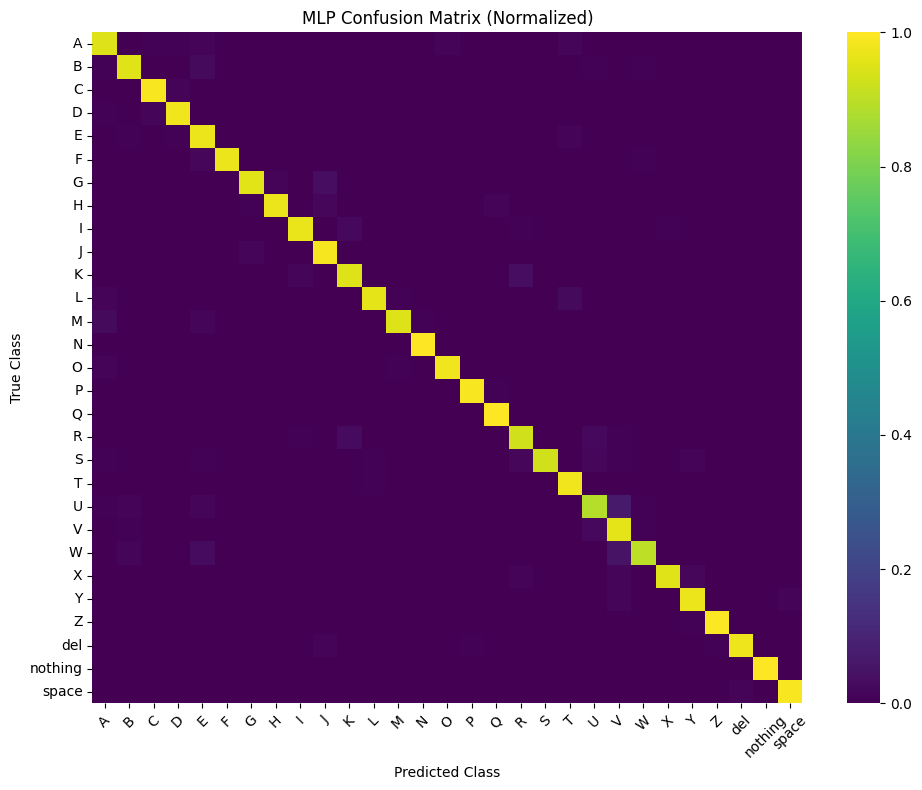

In [15]:
# ========== Confusion Matrix Visualization ==========
cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, cmap="viridis", xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title("MLP Confusion Matrix (Normalized)")
plt.xlabel("Predicted Class"); plt.ylabel("True Class")
plt.xticks(rotation=45); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()